In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression

## Import dataset
leads_dataset = pd.read_csv('../Datasets/dataset.csv')
analysis_df = pd.read_csv('../Datasets/dataset.csv')
leads_dataset.columns = map(str.lower, leads_dataset.columns)

In [2]:
# Create data pre-processing varibles to help
leads_categorical_columns = ['lead_source',
                             'country',
                             'gender',
                             'education_level',
                             'occupation',
                             'industry',
                             'initial_response',
                             'do_not_contact',
                             'general_knowledge',
                             'business_knowledge',
                             'company_size',
                             'lead_quality']

leads_numeric_columns = ['age',
                         'income',
                         'total_calls_attended',
                         'total_meetings_attended',
                         'company_estimated_revenue',]

leads_response_columns = ['lead_score']

In [3]:
#split data for training and testing

leads_x = leads_dataset.drop(leads_response_columns, axis=1)
leads_y = pd.DataFrame(leads_dataset[leads_response_columns])

data_train, data_test, label_train, label_test = train_test_split(leads_x,
                                                                            leads_y,
                                                                            train_size=0.9,
                                                                            test_size=0.1,
                                                                            random_state=42)

In [4]:
# Define a function to cleans / process data into model acceptable form
def pre_process_leads_data(df,
                           numeric_columns,
                           categorical_columns,
                           fitted_scaler,
                           train_df_columns = None):
    ## create new df with selected columns
    df.columns = map(str.lower, df.columns)
    _df = df[list(numeric_columns + categorical_columns)].copy()

    ## scale the numeric columns with the pre-built scaler
    _df[numeric_columns] = fitted_scaler.transform(_df[numeric_columns])

    # First, make categorical text lowercase
    _df[categorical_columns] = _df[categorical_columns].apply(lambda x: x.str.lower())
    # Next, create one-hot-encoded variables, add to dataframe, drop old columns
    _df_dummies = pd.get_dummies(_df[categorical_columns])
    print(_df_dummies.head())
    _df = pd.concat([_df, _df_dummies], axis=1)

    _df.drop(categorical_columns, axis=1, inplace = True)

    if train_df_columns:
        _df = _df.reindex(columns=train_df_columns, fill_value=0)

    return _df

In [5]:
# Create a scaler to scale numerical features
scaler = StandardScaler()
scaler = scaler.fit(data_train[leads_numeric_columns])

In [6]:
# Clean the data using the pre defined function
data_train_clean = pre_process_leads_data(df = data_train,
                                            numeric_columns = leads_numeric_columns,
                                            categorical_columns = leads_categorical_columns,
                                            fitted_scaler = scaler)

data_test_clean = pre_process_leads_data(df = data_test,
                                           numeric_columns = leads_numeric_columns,
                                           categorical_columns = leads_categorical_columns,
                                           fitted_scaler = scaler,
                                           train_df_columns = data_train_clean.columns.tolist())

      lead_source_inbound  lead_source_organic  lead_source_other   
4896                False                False               True  \
4782                False                False              False   
1496                False                False              False   
1957                False                False              False   
9171                False                False              False   

      lead_source_paid  lead_source_referral  country_australia   
4896             False                 False              False  \
4782              True                 False               True   
1496             False                  True              False   
1957             False                  True              False   
9171             False                  True              False   

      country_brazil  country_canada  country_china  country_france  ...   
4896           False           False          False           False  ...  \
4782           False          

In [7]:
# Train the random forest model
num_estimators = 100
min_samples = 4

rf = RandomForestRegressor(n_estimators=num_estimators,
                            min_samples_split=min_samples)
rf.fit(data_train_clean, label_train.values.ravel())

RandomForestRegressor(min_samples_split=4)

In [8]:
# Train Logistic Regression Model
LR_clf = LogisticRegression(max_iter=1000)
LR_clf.fit(data_train_clean, label_train.values.ravel())

LogisticRegression(max_iter=1000)

In [9]:
# Train Gradient Boosting Regressor Regression Model
gbr = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse',
                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3,
                                min_impurity_decrease=0.0, init=None, random_state=None,
                                max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False,
                                validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
gbr.fit(data_train_clean, label_train.values.ravel())

GradientBoostingRegressor()

In [11]:
# Predict using RF Model
rf_pred = rf.predict(data_test_clean)

In [12]:
# Check regression performance of RF Model
rf_mse = mean_squared_error(label_test, rf_pred)
rf_mae = mean_absolute_error(label_test, rf_pred)
rf_r2 = r2_score(label_test, rf_pred)

print(f"Mean Squared Error: {rf_mse}")
print(f"Mean Absolute Error: {rf_mae}")
print(f"R-squared: {rf_r2}")

Mean Squared Error: 58.919443408823426
Mean Absolute Error: 6.222100180902431
R-squared: 0.9282589292169457


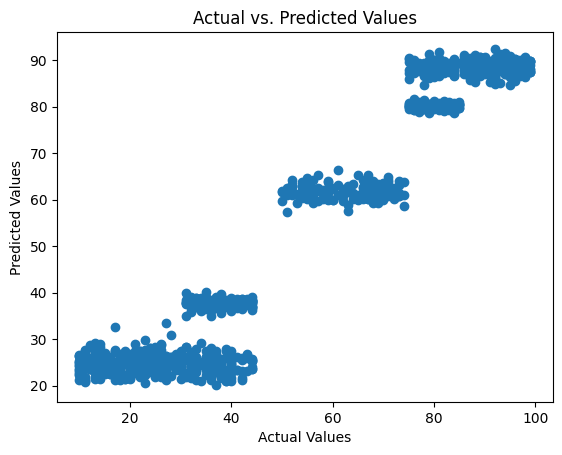

In [13]:
## Plot the perfomance of RF Model
plt.scatter(label_test, rf_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

[41, 71, 88, 59, 71, 42, 95, 27, 17, 80, 87, 21, 34, 33, 69, 15, 92, 18, 42, 36, 39, 76, 66, 41, 51, 16, 87, 21, 42, 38, 78, 76, 71, 71, 27, 92, 41, 87, 57, 34, 44, 78, 30, 81, 31, 81, 71, 78, 81, 84, 55, 14, 56, 27, 99, 28, 77, 36, 98, 82, 84, 37, 38, 75, 94, 41, 75, 23, 23, 78, 11, 88, 58, 98, 88, 42, 96, 29, 28, 91, 16, 83, 39, 69, 43, 94, 81, 96, 18, 24, 32, 22, 16, 75, 84, 69, 37, 12, 36, 36, 83, 15, 57, 43, 35, 97, 87, 44, 11, 93, 30, 34, 73, 75, 22, 55, 11, 77, 93, 72, 11, 68, 13, 30, 78, 51, 87, 63, 37, 97, 44, 83, 92, 15, 24, 36, 92, 37, 82, 24, 86, 38, 37, 90, 20, 39, 24, 94, 78, 63, 33, 28, 60, 31, 36, 16, 10, 94, 19, 52, 95, 56, 14, 93, 79, 76, 38, 39, 10, 87, 80, 37, 35, 11, 95, 90, 86, 34, 59, 27, 39, 79, 16, 57, 40, 27, 94, 14, 76, 90, 30, 80, 52, 89, 15, 68, 83, 90, 93, 54, 38, 31, 88, 71, 14, 84, 28, 80, 24, 80, 84, 42, 14, 11, 39, 42, 27, 11, 23, 86, 11, 23, 41, 91, 25, 67, 37, 21, 89, 13, 80, 81, 19, 32, 70, 30, 88, 85, 32, 18, 17, 96, 79, 67, 79, 77, 17, 78, 84, 66,

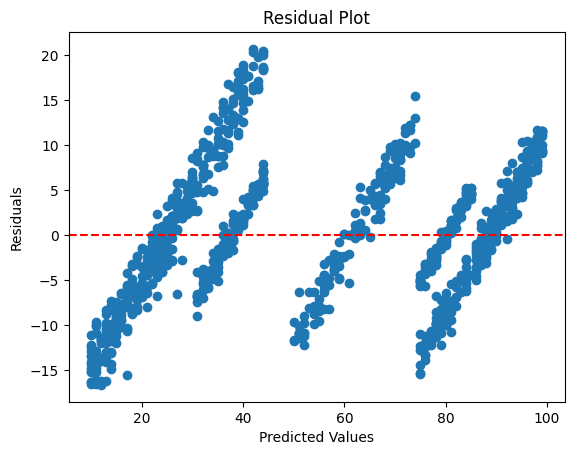

In [14]:
# Plot Residuals for RF model
op_col = []
for i in label_test['lead_score']:
    op_col.append(i)
print(op_col)

rf_residuals = op_col - rf_pred

plt.scatter(label_test, rf_residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

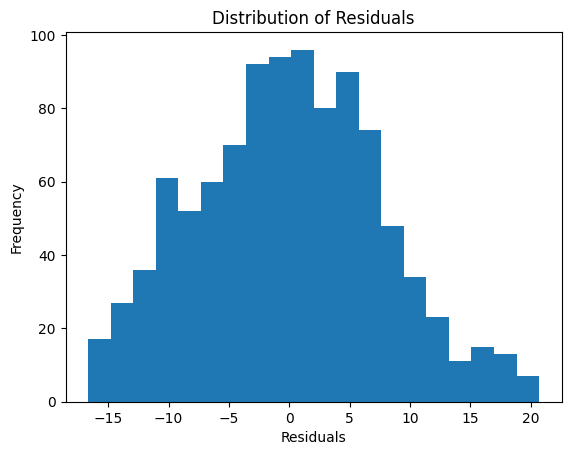

In [15]:
plt.hist(rf_residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

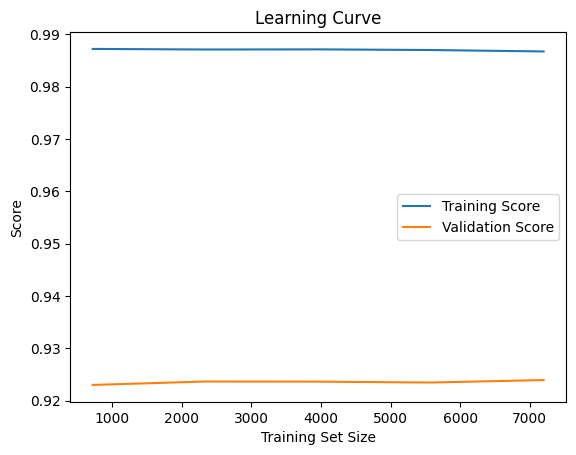

In [58]:
# Plot learning Curve for RF Model
train_sizes, train_scores, val_scores = learning_curve(rf, data_train_clean, label_train.values.ravel(), cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, val_scores_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [16]:
LR_pred = LR_clf.predict(data_test_clean)

In [17]:
# Check regression performance of LR Model
LR_mse = mean_squared_error(label_test, LR_pred)
LR_mae = mean_absolute_error(label_test, LR_pred)
LR_r2 = r2_score(label_test, LR_pred)

print(f"Mean Squared Error: {LR_mse}")
print(f"Mean Absolute Error: {LR_mae}")
print(f"R-squared: {LR_r2}")

Mean Squared Error: 90.405
Mean Absolute Error: 7.441
R-squared: 0.8899217112568523


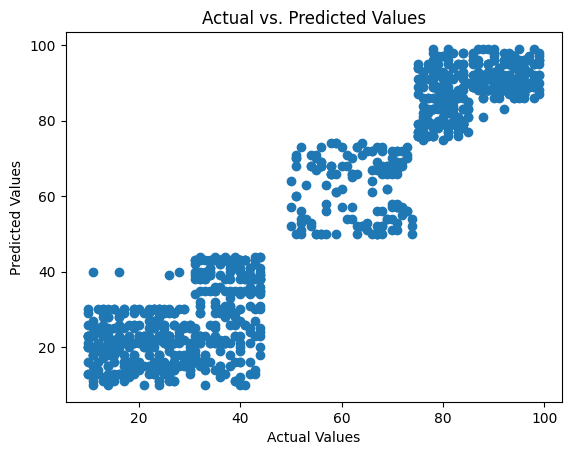

In [18]:
# Plot the perfomance of RF Model
plt.scatter(label_test, LR_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

[41, 71, 88, 59, 71, 42, 95, 27, 17, 80, 87, 21, 34, 33, 69, 15, 92, 18, 42, 36, 39, 76, 66, 41, 51, 16, 87, 21, 42, 38, 78, 76, 71, 71, 27, 92, 41, 87, 57, 34, 44, 78, 30, 81, 31, 81, 71, 78, 81, 84, 55, 14, 56, 27, 99, 28, 77, 36, 98, 82, 84, 37, 38, 75, 94, 41, 75, 23, 23, 78, 11, 88, 58, 98, 88, 42, 96, 29, 28, 91, 16, 83, 39, 69, 43, 94, 81, 96, 18, 24, 32, 22, 16, 75, 84, 69, 37, 12, 36, 36, 83, 15, 57, 43, 35, 97, 87, 44, 11, 93, 30, 34, 73, 75, 22, 55, 11, 77, 93, 72, 11, 68, 13, 30, 78, 51, 87, 63, 37, 97, 44, 83, 92, 15, 24, 36, 92, 37, 82, 24, 86, 38, 37, 90, 20, 39, 24, 94, 78, 63, 33, 28, 60, 31, 36, 16, 10, 94, 19, 52, 95, 56, 14, 93, 79, 76, 38, 39, 10, 87, 80, 37, 35, 11, 95, 90, 86, 34, 59, 27, 39, 79, 16, 57, 40, 27, 94, 14, 76, 90, 30, 80, 52, 89, 15, 68, 83, 90, 93, 54, 38, 31, 88, 71, 14, 84, 28, 80, 24, 80, 84, 42, 14, 11, 39, 42, 27, 11, 23, 86, 11, 23, 41, 91, 25, 67, 37, 21, 89, 13, 80, 81, 19, 32, 70, 30, 88, 85, 32, 18, 17, 96, 79, 67, 79, 77, 17, 78, 84, 66,

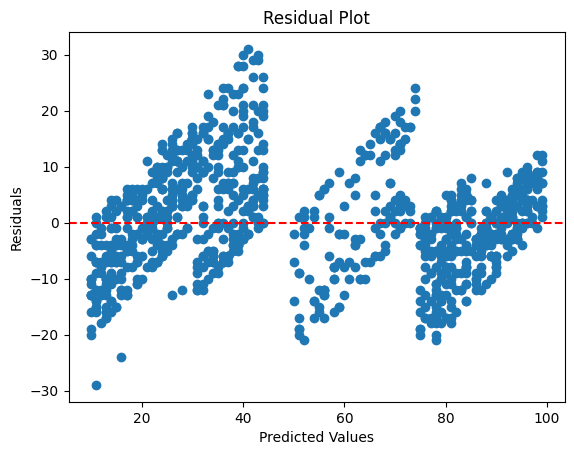

In [19]:
# Plot Residuals for LR model
op_col = []
for i in label_test['lead_score']:
    op_col.append(i)
print(op_col)

LR_residuals = op_col - LR_pred

plt.scatter(label_test, LR_residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

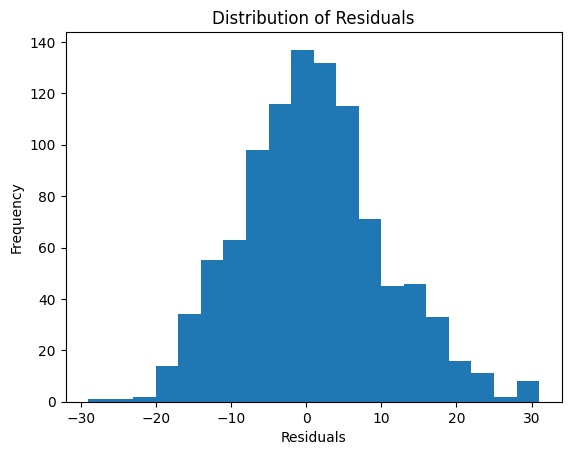

In [20]:
plt.hist(LR_residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

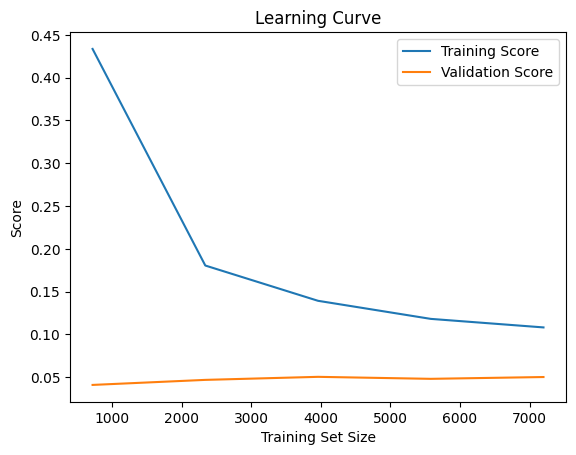

In [67]:
# Plot learning Curve for LR Model
LR_train_sizes, LR_train_scores, LR_val_scores = learning_curve(LR_clf, data_train_clean, label_train.values.ravel(), cv=5)

LR_train_scores_mean = np.mean(LR_train_scores, axis=1)
LR_val_scores_mean = np.mean(LR_val_scores, axis=1)

plt.plot(LR_train_sizes, LR_train_scores_mean, label='Training Score')
plt.plot(LR_train_sizes, LR_val_scores_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [21]:
gbr_pred = gbr.predict(data_test_clean)

In [22]:
# Check regression performance of LR Model
gbr_mse = mean_squared_error(label_test, gbr_pred)
gbr_mae = mean_absolute_error(label_test, gbr_pred)
gbr_r2 = r2_score(label_test, gbr_pred)

print(f"Mean Squared Error: {gbr_mse}")
print(f"Mean Absolute Error: {gbr_mae}")
print(f"R-squared: {gbr_r2}")

Mean Squared Error: 56.66322163630238
Mean Absolute Error: 6.088248018709181
R-squared: 0.9310061338156311


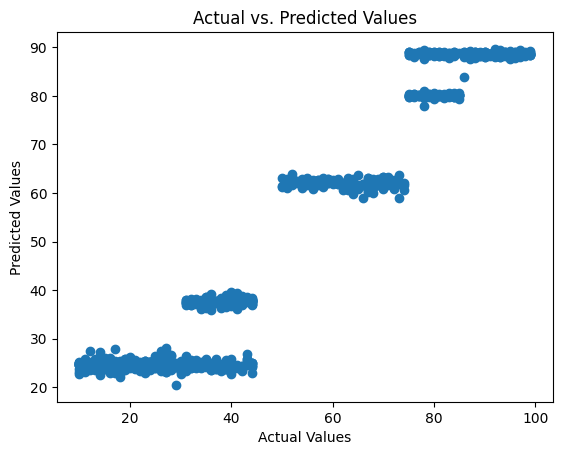

In [23]:
# Plot the perfomance of RF Model
plt.scatter(label_test, gbr_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

[41, 71, 88, 59, 71, 42, 95, 27, 17, 80, 87, 21, 34, 33, 69, 15, 92, 18, 42, 36, 39, 76, 66, 41, 51, 16, 87, 21, 42, 38, 78, 76, 71, 71, 27, 92, 41, 87, 57, 34, 44, 78, 30, 81, 31, 81, 71, 78, 81, 84, 55, 14, 56, 27, 99, 28, 77, 36, 98, 82, 84, 37, 38, 75, 94, 41, 75, 23, 23, 78, 11, 88, 58, 98, 88, 42, 96, 29, 28, 91, 16, 83, 39, 69, 43, 94, 81, 96, 18, 24, 32, 22, 16, 75, 84, 69, 37, 12, 36, 36, 83, 15, 57, 43, 35, 97, 87, 44, 11, 93, 30, 34, 73, 75, 22, 55, 11, 77, 93, 72, 11, 68, 13, 30, 78, 51, 87, 63, 37, 97, 44, 83, 92, 15, 24, 36, 92, 37, 82, 24, 86, 38, 37, 90, 20, 39, 24, 94, 78, 63, 33, 28, 60, 31, 36, 16, 10, 94, 19, 52, 95, 56, 14, 93, 79, 76, 38, 39, 10, 87, 80, 37, 35, 11, 95, 90, 86, 34, 59, 27, 39, 79, 16, 57, 40, 27, 94, 14, 76, 90, 30, 80, 52, 89, 15, 68, 83, 90, 93, 54, 38, 31, 88, 71, 14, 84, 28, 80, 24, 80, 84, 42, 14, 11, 39, 42, 27, 11, 23, 86, 11, 23, 41, 91, 25, 67, 37, 21, 89, 13, 80, 81, 19, 32, 70, 30, 88, 85, 32, 18, 17, 96, 79, 67, 79, 77, 17, 78, 84, 66,

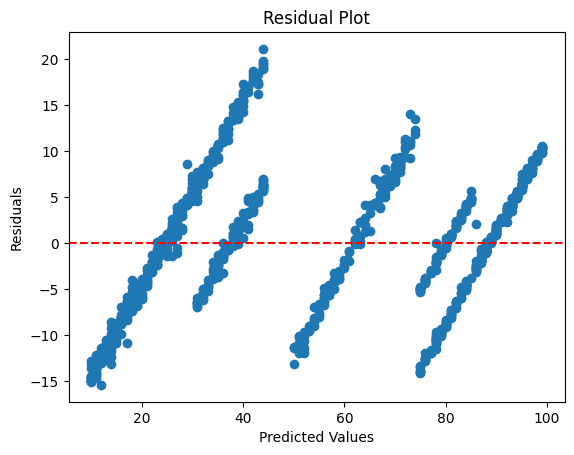

In [24]:
# Plot Residuals for LR model
op_col = []
for i in label_test['lead_score']:
    op_col.append(i)
print(op_col)

gbr_residuals = op_col - gbr_pred

plt.scatter(label_test, gbr_residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

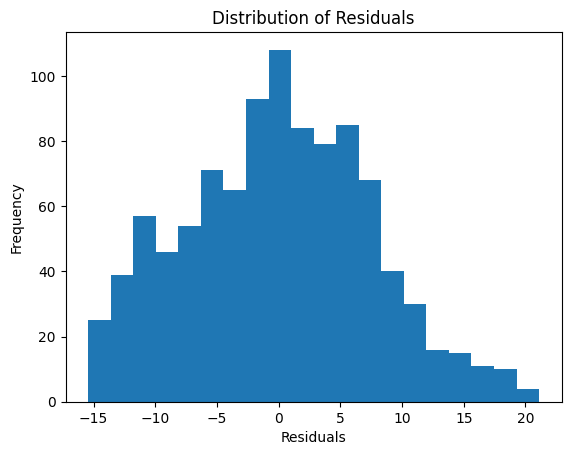

In [25]:
plt.hist(gbr_residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

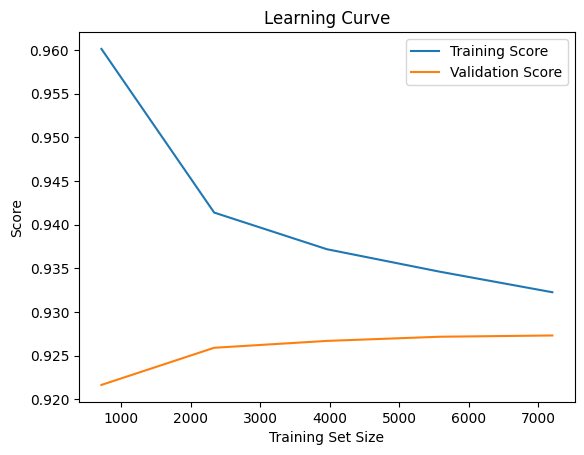

In [73]:
# Plot learning Curve for LR Model
gbr_train_sizes, gbr_train_scores, gbr_val_scores = learning_curve(gbr, data_train_clean, label_train.values.ravel(), cv=5)

gbr_train_scores_mean = np.mean(gbr_train_scores, axis=1)
gbr_val_scores_mean = np.mean(gbr_val_scores, axis=1)

plt.plot(gbr_train_sizes, gbr_train_scores_mean, label='Training Score')
plt.plot(gbr_train_sizes, gbr_val_scores_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [ ]:
# Define the hyperparameters to test
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbr2 = GradientBoostingRegressor()
grid_search = GridSearchCV(gbr2, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(data_train_clean, label_train.values.ravel())

# Print the best hyperparameters and test accuracy
print("Best hyperparameters: ", grid_search.best_params_)
gbr2_pred = grid_search.predict(data_test_clean)
test_rmse = mean_squared_error(data_test, gbr2_pred, squared=False)
print("Test RMSE: ", test_rmse)

C:\Users\hp\PycharmProjects\leadScoringSystem\venv\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hp\PycharmProjects\leadScoringSystem\venv\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hp\PycharmProjects\leadScoringSystem\venv\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hp\PycharmProjects\leadScoringSystem\venv\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y 

In [26]:
# Testing Frontend Request
leads_columns = ['lead_source',
                             'country',
                             'age',
                             'gender',
                             'education_level',
                             'occupation',
                             'industry',
                             'income',
                             'initial_response',
                             'do_not_contact',
                             'total_calls_attended',
                             'total_meetings_attended',
                             'general_knowledge',
                             'business_knowledge',
                             'company_size',
                             'company_estimated_revenue',
                             'lead_quality']
lead = [
    'REFERRAL',
    'Japan',
    44,
    'OTHER',
    'HIGH SCHOOL',
    'SELF-EMPLOYED',
    'MANUFACTURING',
    87000,
    'POSITIVE',
    'No',
    5,
    3,
    'NOVICE',
    'INTERMEDIATE',
    'LARGE',
    272000,
    'HOT']

lead = pd.DataFrame([lead], columns= leads_columns)
lead[leads_categorical_columns] = lead[leads_categorical_columns].apply(lambda x: x.str.lower())
lead = pd.get_dummies(lead)
#lead.head()
#lead.head()
new_df = pd.DataFrame(columns=data_train_clean.columns)
new_df = pd.concat([new_df,lead], axis=0, ignore_index = True, sort = False)
empty_cols = new_df.columns[new_df.isnull().any()]
new_df[empty_cols] = new_df[empty_cols].fillna(False)
new_df[leads_numeric_columns] = scaler.transform(new_df[leads_numeric_columns])
print(gbr.predict(new_df))
#lead_dummy = pd.get_dummies(lead,columns=leads_categorical_columns)
#lead_dummy.head()

[64.46618766]


In [27]:
joblib.dump(gbr,'model_final.joblib')

['model_final.joblib']